# Simulating a quantum circuit using the density matrix formalism


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# helper functions for manipulating and visualizing density matrices
from src.visualizers.density_matrix import density_matrix_bars
from src.backends.density_matrix.functions import ketz0_state, ketz1_state, tensor, ket2dm, partial_trace, fidelity

First, we create the quantum circuit by adding gates, specifying the registers (quantum and classical) that they act on.

In [2]:
from src.circuit import CircuitDAG
circuit = CircuitDAG(5, 1)

# import the relevant operations to add to the circuit
from src.ops import Hadamard, CNOT, MeasurementZ

# build up the quantum circuit for a 4-qubit GHZ state
circuit.add(Hadamard(register=4))
circuit.add(CNOT(control=4, target=0))
circuit.add(CNOT(control=4, target=1))
circuit.add(Hadamard(register=1))
circuit.add(Hadamard(register=1))

circuit.add(CNOT(control=4, target=2))
circuit.add(Hadamard(register=2))
circuit.add(Hadamard(register=2))

circuit.add(CNOT(control=4, target=3))
circuit.add(Hadamard(register=3))

circuit.add(Hadamard(register=4))
circuit.add(CNOT(control=4, target=3))
circuit.add(Hadamard(register=3))

circuit.add(MeasurementZ(register=4, c_register=0))

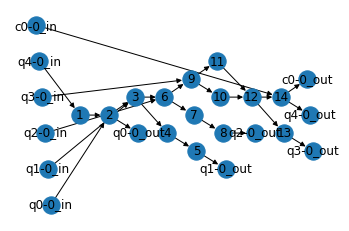

In [3]:
# plot the circuit as a directed, acyclic graph
circuit.show()

Now, we select a backend compiler to simulate the evolution of the quantum circuit. We currently can do this for density matrices, simulating the circuit effect by applying unitary gates.

In [4]:
from src.backends.density_matrix.compiler import DensityMatrixCompiler

compiler = DensityMatrixCompiler()
state = compiler.compile(circuit)  # this returns a DensityMatrix object, and you can get underlying complex array as state.data

In [5]:
# trace out the ancilla qubit
state_a = partial_trace(state.data, keep=(0, 1, 2, 3), dims=5*[2])

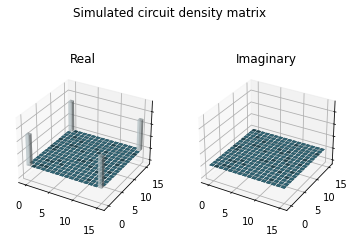

In [6]:
fig, ax = density_matrix_bars(state_a)
fig.suptitle("Simulated circuit density matrix")
plt.show()

In [8]:
# compare to the ideal density matrix
ideal_state = ket2dm((tensor(4 * [ketz0_state()]) + tensor(4 * [ketz1_state()])) / np.sqrt(2))
f = fidelity(state_a, ideal_state)
print(f"Fidelity with ideal state: {f}")

Fidelity with ideal state: 1.0000000000000004


In [7]:
# save the resulting quantum state
from src.io import IO

io = IO.new_directory(folder="example-folder", include_date=True, include_id=True)
io.save_np_array(state_a, "partial_density_matrix.np")

22/05/2022, 18:41:39 | Saved to C:\Users\benma\OneDrive - University of Waterloo\Backups\Desktop (BACKUP)\1 - Projects\AF Inverse Graph Design\data\2022-05-22 example-folder - b2b7\partial_density_matrix.np successfully.


Future work will build metrics (e.g., fidelity, circuit depth, success probability) and solvers (e.g., random search, decompositions, etc.), as well as other backend compilers.

In [8]:
from src import metrics, solvers

DensityMatrix
[[ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  5.00000000e-01+0.j  0.00000000e+00+0.j ...
   1.37804281e-17+0.j  0.00000000e+00+0.j  5.00000000e-01+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 ...
 [ 0.00000000e+00+0.j  2.78957589e-18+0.j  0.00000000e+00+0.j ...
  -4.62637368e-35+0.j  0.00000000e+00+0.j  2.78957589e-18+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j ...
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  5.00000000e-01+0.j  0.00000000e+00+0.j ...
   1.37804281e-17+0.j  0.00000000e+00+0.j  5.00000000e-01+0.j]]
DensityMatrix
[[ 5.00000000e-01+0.j  0.00000000e+00+0.j  1.37804281e-17+0.j ...
   0.00000000e+00+0.j  5.00000000e-01+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j .

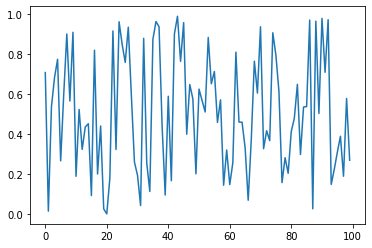

In [9]:
target = ket2dm((tensor(4 * [ketz0_state()]) + tensor(4 * [ketz1_state()])) / np.sqrt(2))

# we pass one metric to use as the cost function. we can also pass more to be evaluated but not used as the cost
metric = metrics.MetricFidelity()

# define the solver (all methods are encapsulated in the class definition)
solver = solvers.RandomSearchSolver(target=target, metric=metric, compiler=compiler, circuit=circuit)

# call .solve to implement the solver algorithm
solver.solve()

# we now have access to the metrics (don't need to pass anything back, as we are logging it in the Metric instance)
print(metric.log)

plt.plot(metric.log)
plt.show()